In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import torch
import torchvision
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings("ignore")

In [2]:
emotion_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

def one_hot_encoder(label:int, num_labels:int) -> np.ndarray:
    """Takes a numeric label value and returns the corresponding one-hot-encoding vector given the number of labels.
    Labels need to start from zero with step size 1.
    Example: if there are label {0,1,2}, so num_labels=3. Then the method will transform {1} into [0,1,0].
    Example: if there are labels {0,5,9} the method will not work as the labels do not have step size 1 between them.

    Args:
        label (int): label to be transformed into a one-hot-encoding vector
        num_labels (int): number of labels in total

    Returns:
        np.ndarray: one-hot-encoding vector
    """    
    one_hot_vector = np.zeros(num_labels)
    one_hot_vector[label] = 1
    return one_hot_vector

In [3]:
df = pd.read_csv('C:/Users/louis/github_vs/archive/fer2013/fer2013/fer2013.csv')
num_emotions = df.emotion.value_counts().shape[0]

df_train = df[df['Usage']=='Training'].drop(labels=['Usage'], axis=1)
df_val = df[df['Usage']=='PublicTest'].drop(labels=['Usage'], axis=1)
df_test = df[df['Usage']=='PrivateTest'].drop(labels=['Usage'], axis=1)

X_train = df_train.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_train = np.stack(X_train, axis=0)/255
y_train = df_train.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_train = np.stack(y_train, axis=0)
X_val = df_val.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_val = np.stack(X_val, axis=0)/255
y_val = df_val.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_val = np.stack(y_val, axis=0)
X_test = df_test.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X_test = np.stack(X_test, axis=0)/255
y_test = df_test.emotion.apply(lambda x: one_hot_encoder(x, num_labels=num_emotions))
y_test = np.stack(y_test, axis=0)

print(f'Shape of X_train, y_train: {X_train.shape}, {y_train.shape}')
print(f'Shape of X_val, y_val: {X_val.shape}, {y_val.shape}')
print(f'Shape of X_test, y_test: {X_test.shape}, {y_test.shape}', end='')

Shape of X_train, y_train: (28709, 48, 48, 1), (28709, 7)
Shape of X_val, y_val: (3589, 48, 48, 1), (3589, 7)
Shape of X_test, y_test: (3589, 48, 48, 1), (3589, 7)

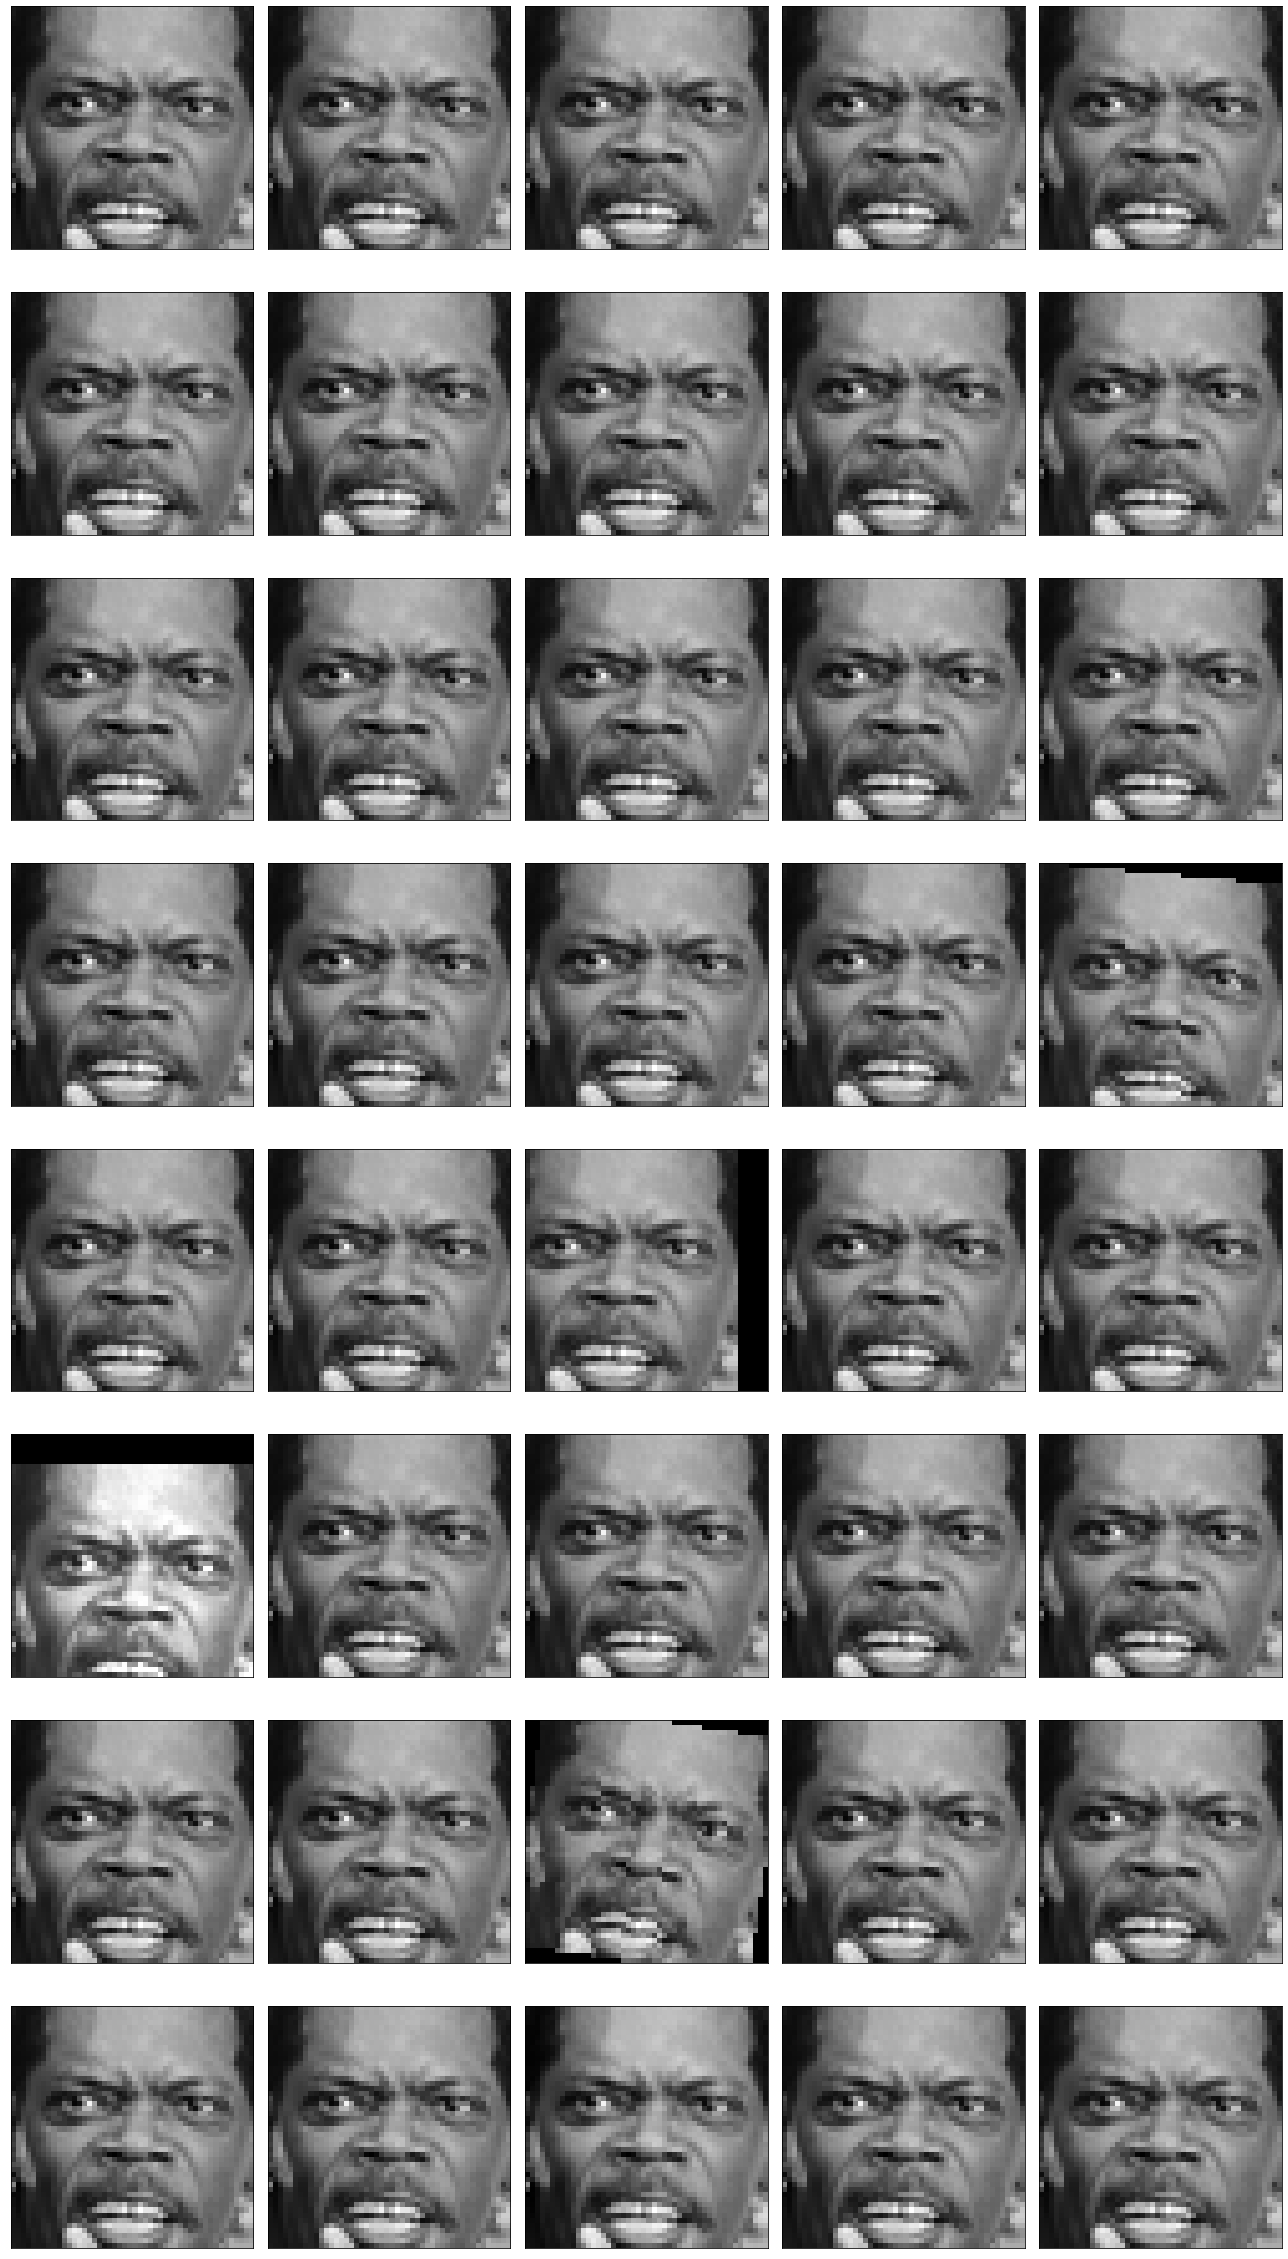

In [4]:
# decided to use the pytorch RandAugment() method as it does exactly what we want
def augment_image(image:np.ndarray):
    prob_for_augmentation = 0.1
    if np.random.random() < prob_for_augmentation:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.ConvertImageDtype(dtype=torch.uint8),
            torchvision.transforms.RandAugment()
        ])
        augmented_image = transform((image*255).astype(np.uint8))
        return np.rollaxis(augmented_image.numpy(), axis=0, start=3)/255
    else: return image

image_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=augment_image)

# testing to see what outputs the augment_image method returns
# on average, one for every (1/prob_for_augmentation) images will be transformed
fig = plt.figure(figsize=(18, 32))
for i in range(40):
    ax = plt.subplot(8, 5, i+1)
    ax.imshow(augment_image(X_train[10]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# alternative ImageDataGenerator function implemented in TensorFlow. 
# I don't like it as much as it does not let you control how many images are augmented. All images are augmented every epoch, which is not what we want I think.
# testing how the augmentations produced by ImageDataGenerator look like
# image_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True, horizontal_flip=True, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, shear_range=10, rescale=1/255.)
# image_augmenter.fit(X_train)
# test = image_augmenter.random_transform(X_train[10])
# plt.imshow(test, cmap='gray')
# print(test.shape)

Emotion encoding:
- 0: anger
- 1: disgust
- 2: fear
- 3: happiness
- 4: sadness
- 5: surprise
- 6: neutral

In [5]:
def create_model(**kwargs) -> tf.keras.Model:
    """creates a keras model which has the architecture pre-specified. 
    The hyperparameters for the model can be passed as keyword arguments and will be used by the model.
    Which parameters can be specified as keyword arguments can be inferred from the "params" dictionary declared in this method.
    In order to adapt for entirely different archtictures, you might want to add further items to the "params" dictionary to allow
    the method to specify the additional (or new) hyper parameters.

    Returns:
        tf.keras.Model: compiled keras model
    """    
    # define default parameter values if not otherwise specified through inputs
    params={'learning_rate': 0.005, 'filters1': 64, 'filters2': 64, 
                    'kernel_size1': 3, 'kernel_size2': 3, 
                    'strides1': (1,1), 'strides2': (1,1),
                    'pool_size1': (3,3), 'pool_size2': (3,3), 
                    'dense_units': 16, 'dropout': 0}
    for key, value in kwargs.items():
        if key in params:
            params[key] = value

    model = keras.models.Sequential()

    model.add(keras.layers.Conv2D(filters=params['filters1'], kernel_size=params['kernel_size1'],
                                    strides=params['strides1'], activation='relu', input_shape=(48,48,1), data_format='channels_last'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=params['pool_size1']))
    model.add(keras.layers.Conv2D(filters=params['filters2'], kernel_size=params['kernel_size2'], strides=params['strides2'], activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=params['pool_size2']))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=params['dense_units'], activation='relu'))
    model.add(keras.layers.Dropout(rate=params['dropout']))
    model.add(keras.layers.Dense(units=7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [6]:
# early stopping might need adaptation depending on how the convergence behavior of the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True, min_delta=0)

def train_model(epochs:int=100, batch_size:int=64, plot_loss:bool=True, run_on_mac:bool=False, **kwargs):
    """Trains a keras model with architecture specified in the create_model() method.
    Values for hyper parameters that should be used to build the model can be passed as keyword arguments
    or as a dictionary (compare create_model() method to see which ones are available).
    Parameters for the training of the model can be passed directly as inputs to this method.

    Args:
        epochs (int, optional): Maximum number of epochs to train, if early stopping does not cause earlier termination. Defaults to 500.
        batch_size (int, optional): size of a single batch. Defaults to 64.
        plot_loss (bool, optional): whether or not to plot a loss curve at the end of training. Defaults to True.
        run_on_mac (bool, optional): only set to true if you are using a mac and want to utilize its CPU instead of GPU. Defaults to False.

    Returns:
        tf.keras.Model, tf.keras.callbacks.History: returns the trained model and the training history
    """    

    model_params = ['learning_rate', 'filters1', 'filters2', 'kernel_size1', 'kernel_size2', 'strides1', 'strides2', 'dense_units', 'pool_size1', 'pool_size2', 'dropout']
    model_kwargs = {}
    for key, value in kwargs.items():
        if key in model_params:
            model_kwargs[key] = value
    
    model = create_model(**model_kwargs)

    image_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=augment_image)
    image_augmenter.fit(X_train)

    if run_on_mac:
        with tf.device('/cpu:0'): # only added this because the code runs quicker on my cpu than on my gpu
            history = model.fit(
                    image_augmenter.flow(X_train, y_train, batch_size=batch_size), 
                    validation_data=(X_val, y_val), 
                    steps_per_epoch=len(X_train)/batch_size, epochs=epochs, 
                    callbacks=[early_stopping], use_multiprocessing=False
                )
    else:
            history = model.fit(
                    image_augmenter.flow(X_train, y_train, batch_size=batch_size), 
                    validation_data=(X_val, y_val), 
                    steps_per_epoch=len(X_train)/epochs, epochs=epochs, 
                    callbacks=[early_stopping], use_multiprocessing=False
                )

    if plot_loss:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'], '--')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()

    test_accuracy = np.round(model.evaluate(x=X_test, y=y_test, workers=12, use_multiprocessing=False, verbose=0)[1], 6)
    print(f'Accuracy on test set: {test_accuracy}')

    return model, history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                        

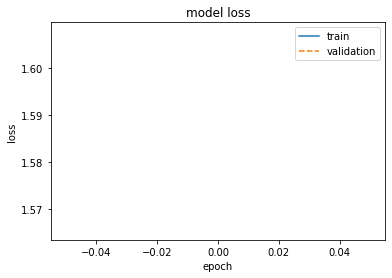

Accuracy on test set: 0.341599


In [7]:
model, history = train_model(epochs = 2)

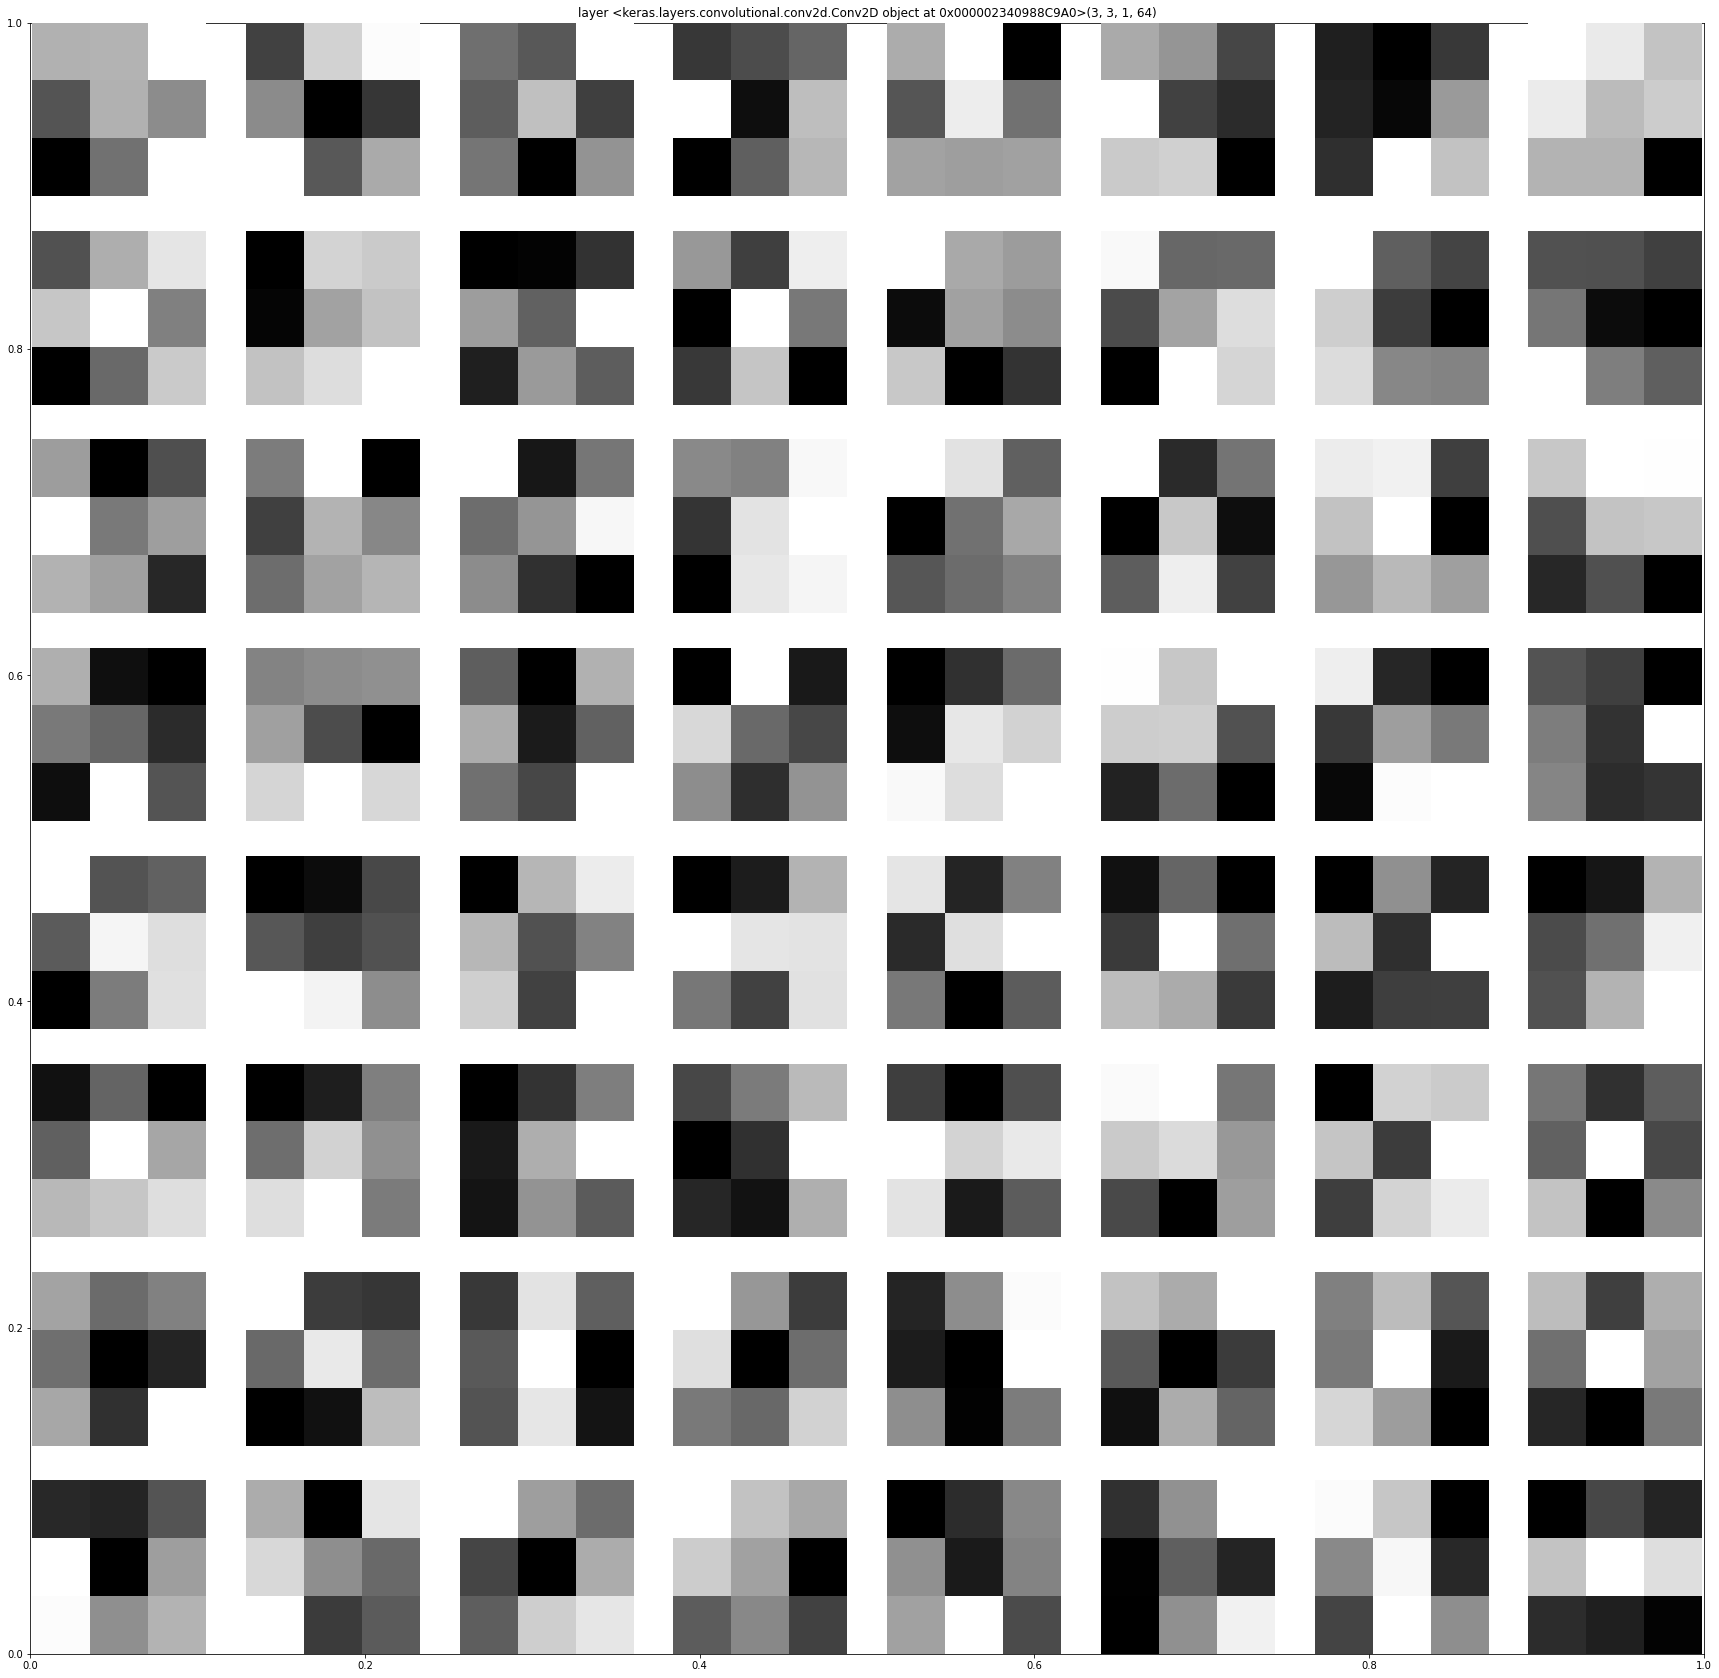

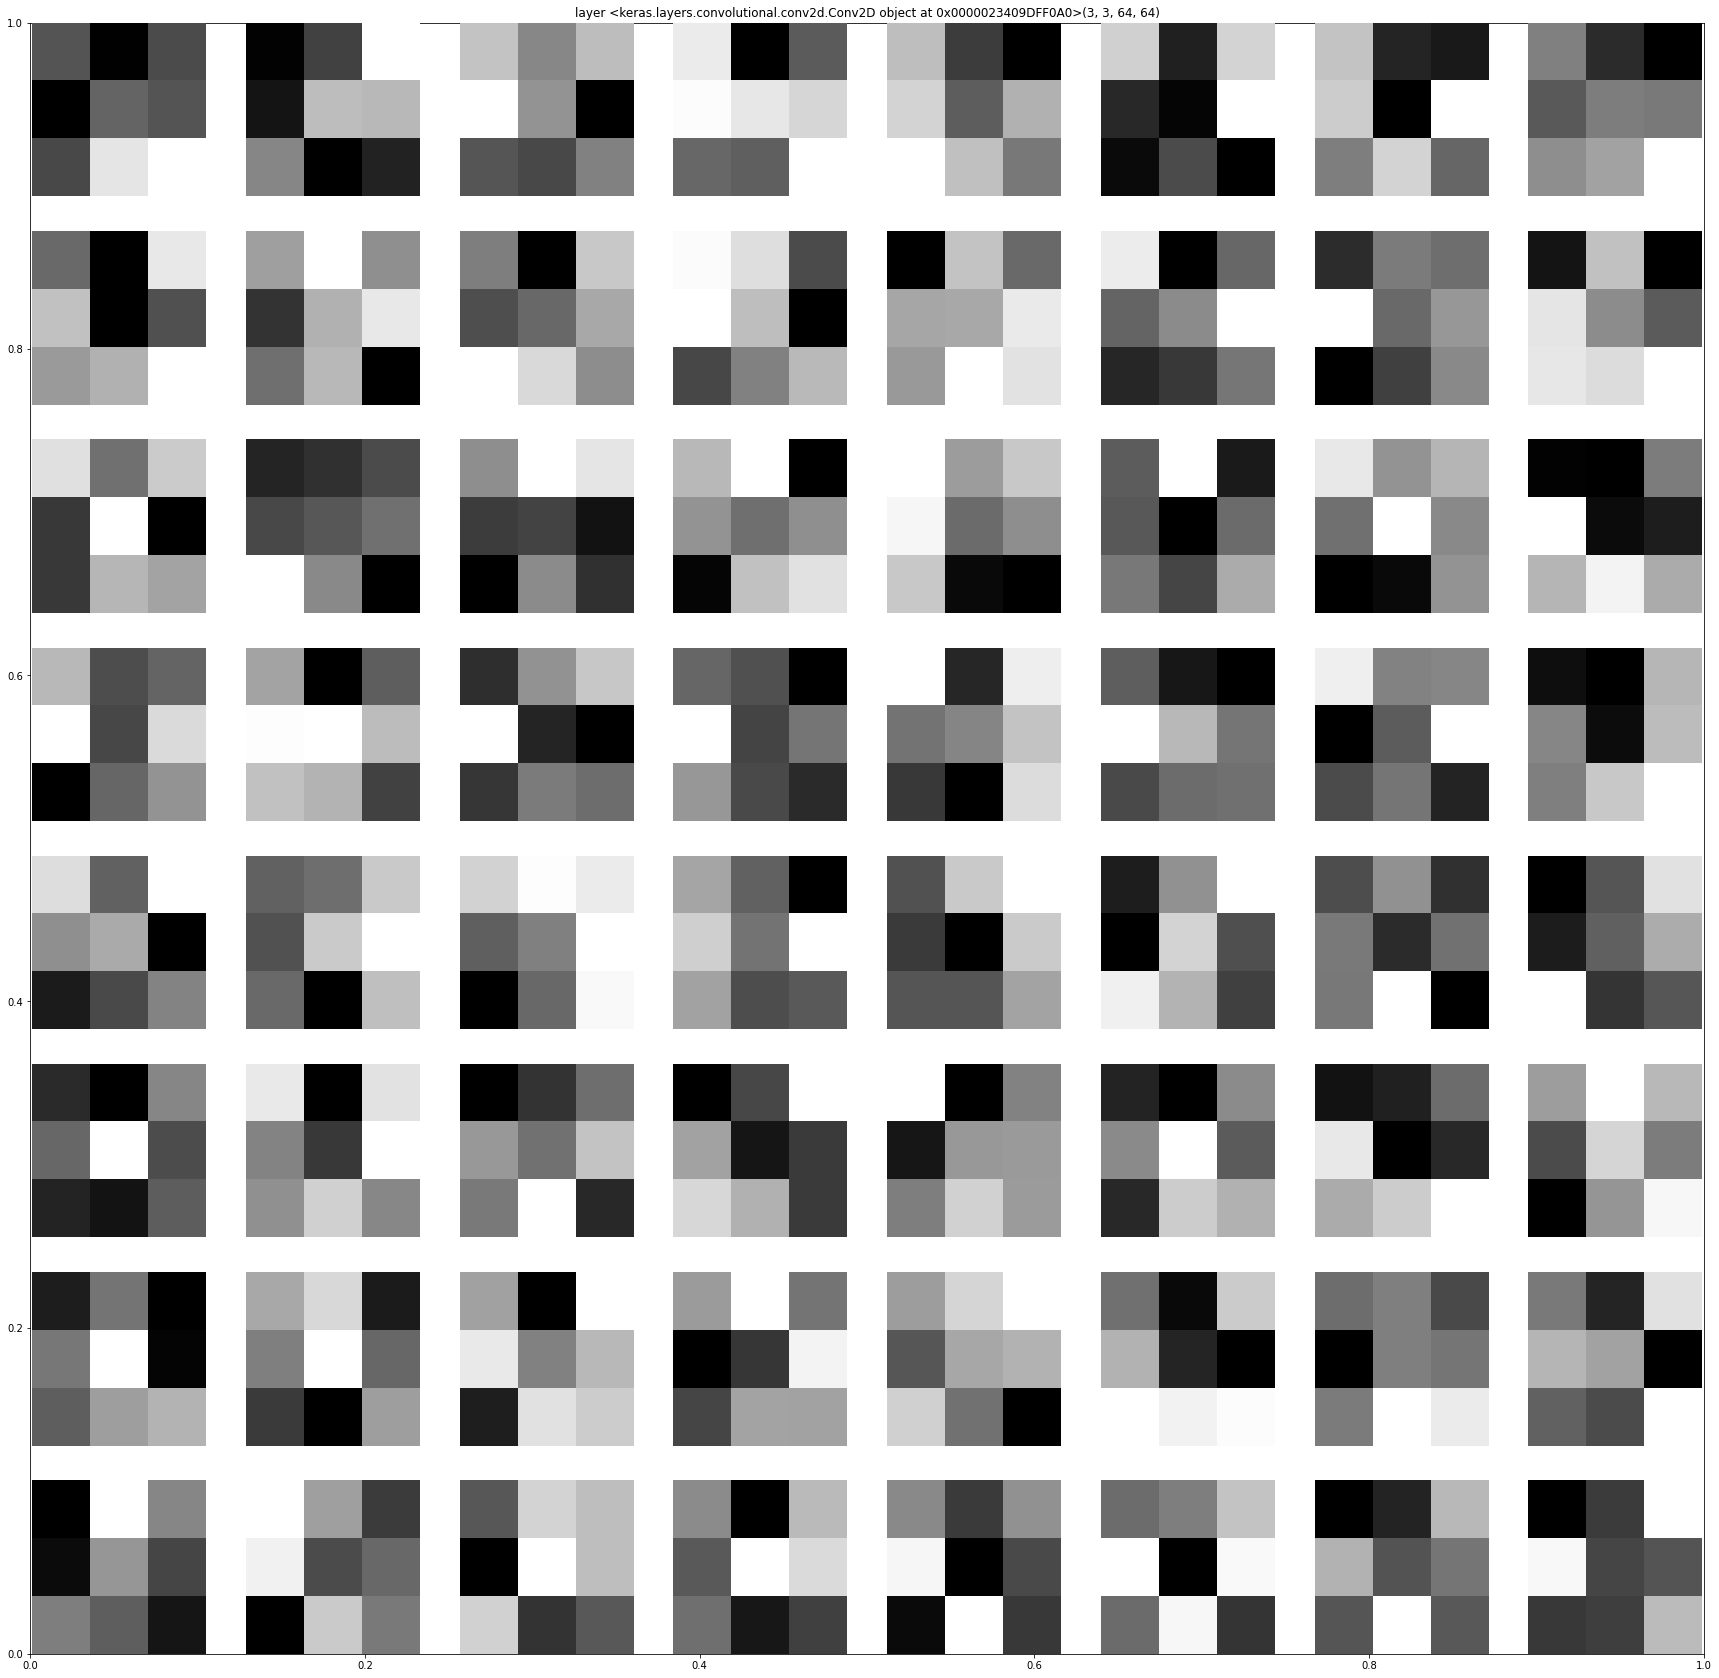

In [8]:
# print filters of the model
for layer in model.layers:
    if 'conv' in layer.name: # do with also have to do the maxpooling layers?
        fig = plt.figure(figsize=(30,30))

        weights_n = layer.get_weights()[0]
        plt.title(str("layer "+layer.__str__()+weights_n.shape.__str__()))
        size = np.ceil(np.sqrt(weights_n.shape[3])) # size of the grid
        for filter in range(weights_n.shape[3]):
            fig.add_subplot(size,size,filter+1)
            plt.imshow(weights_n[:,:,0,filter], cmap='gray') # are there 3x3 filters of 64/ or 64 times 3x3 filters?
            plt.axis('off')

label =  anger
1/1 [==============================] - 0s 54ms/step


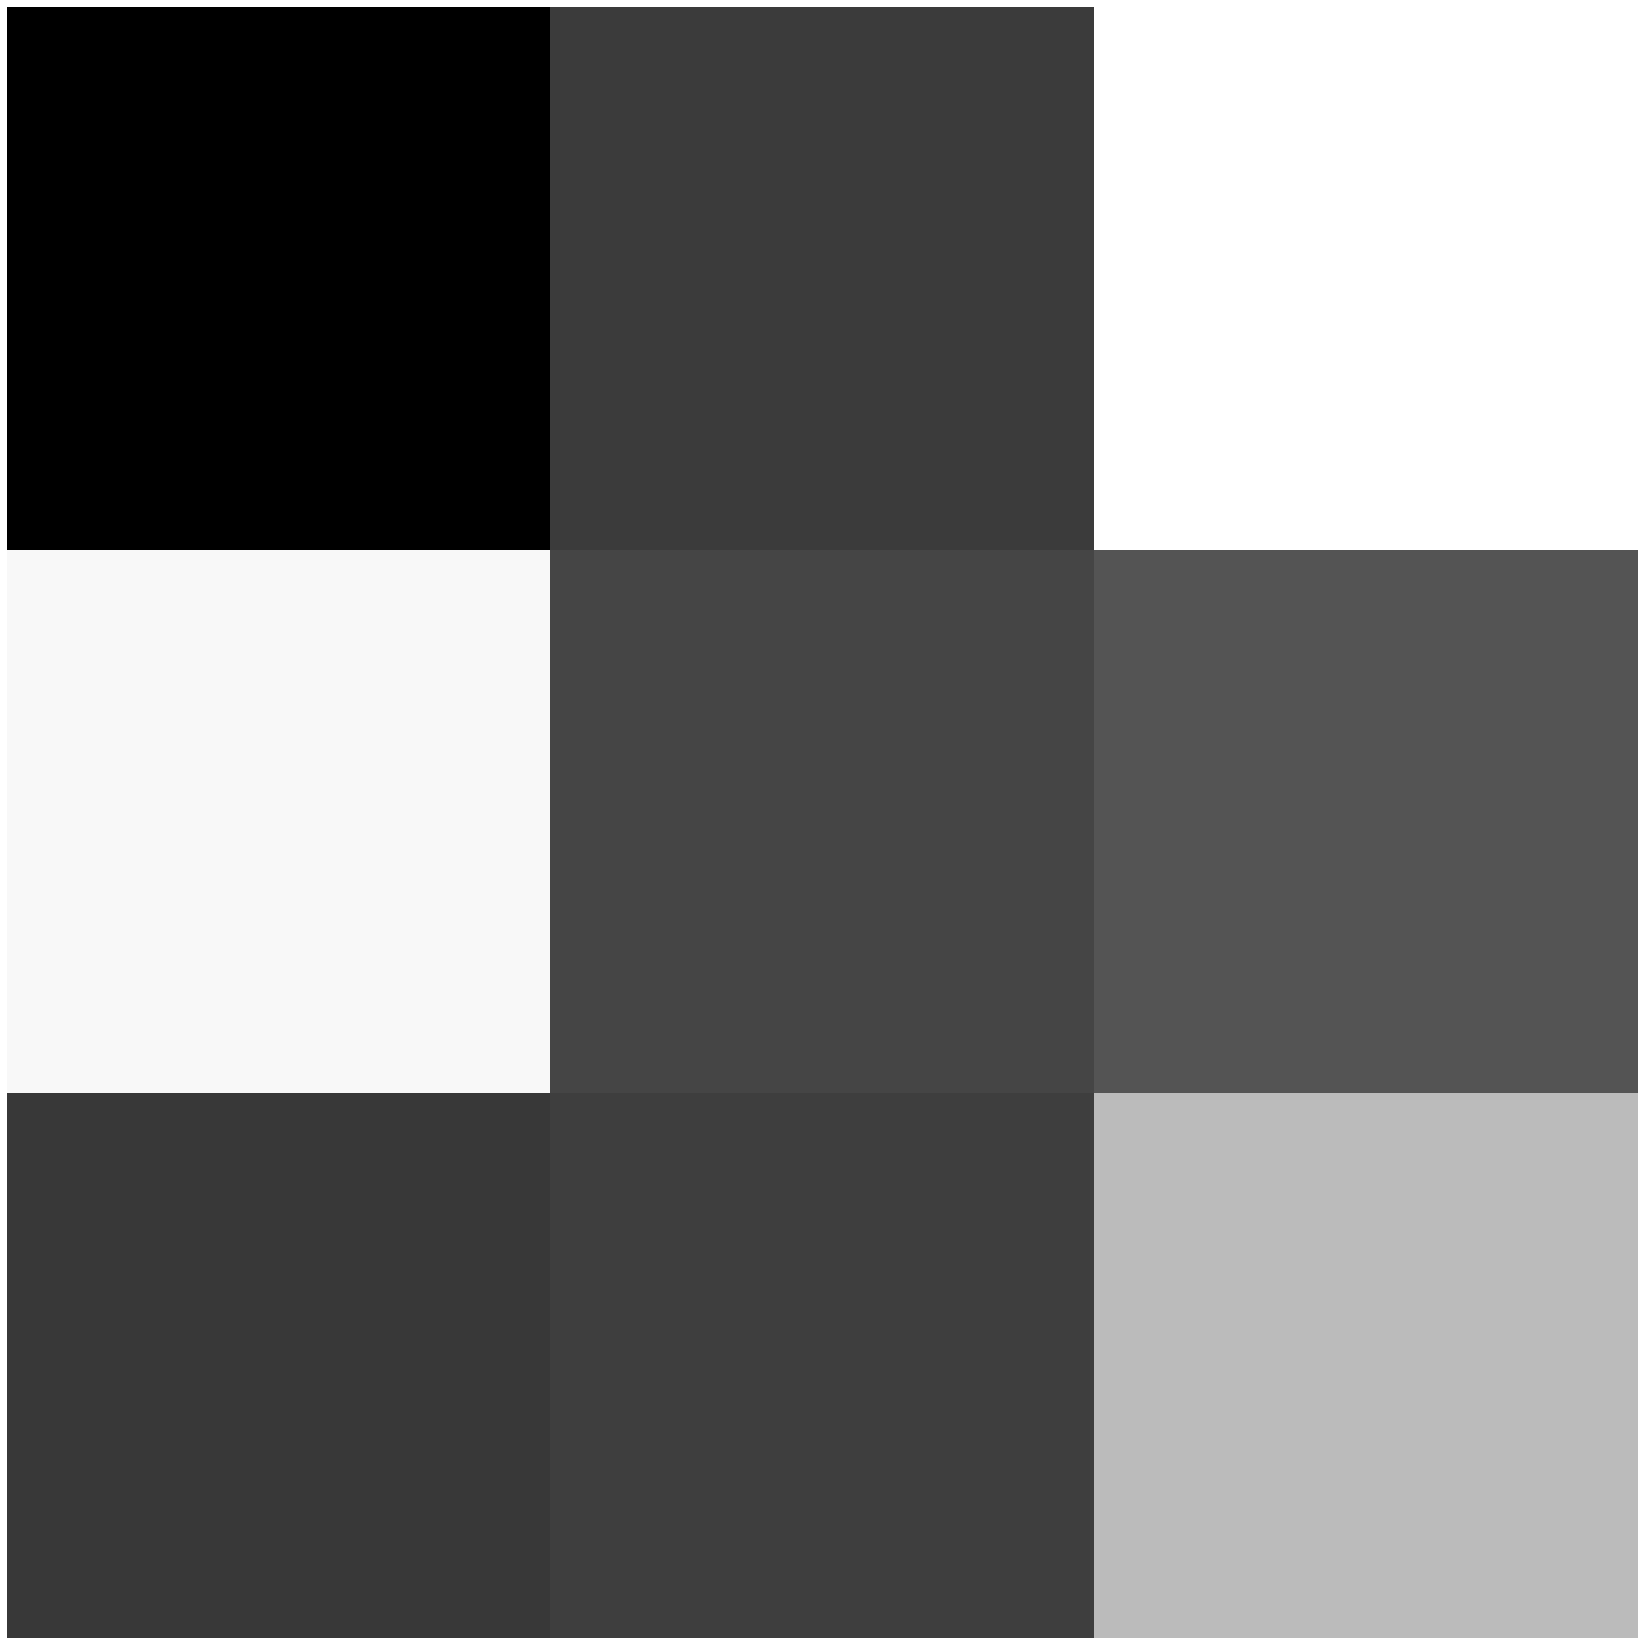

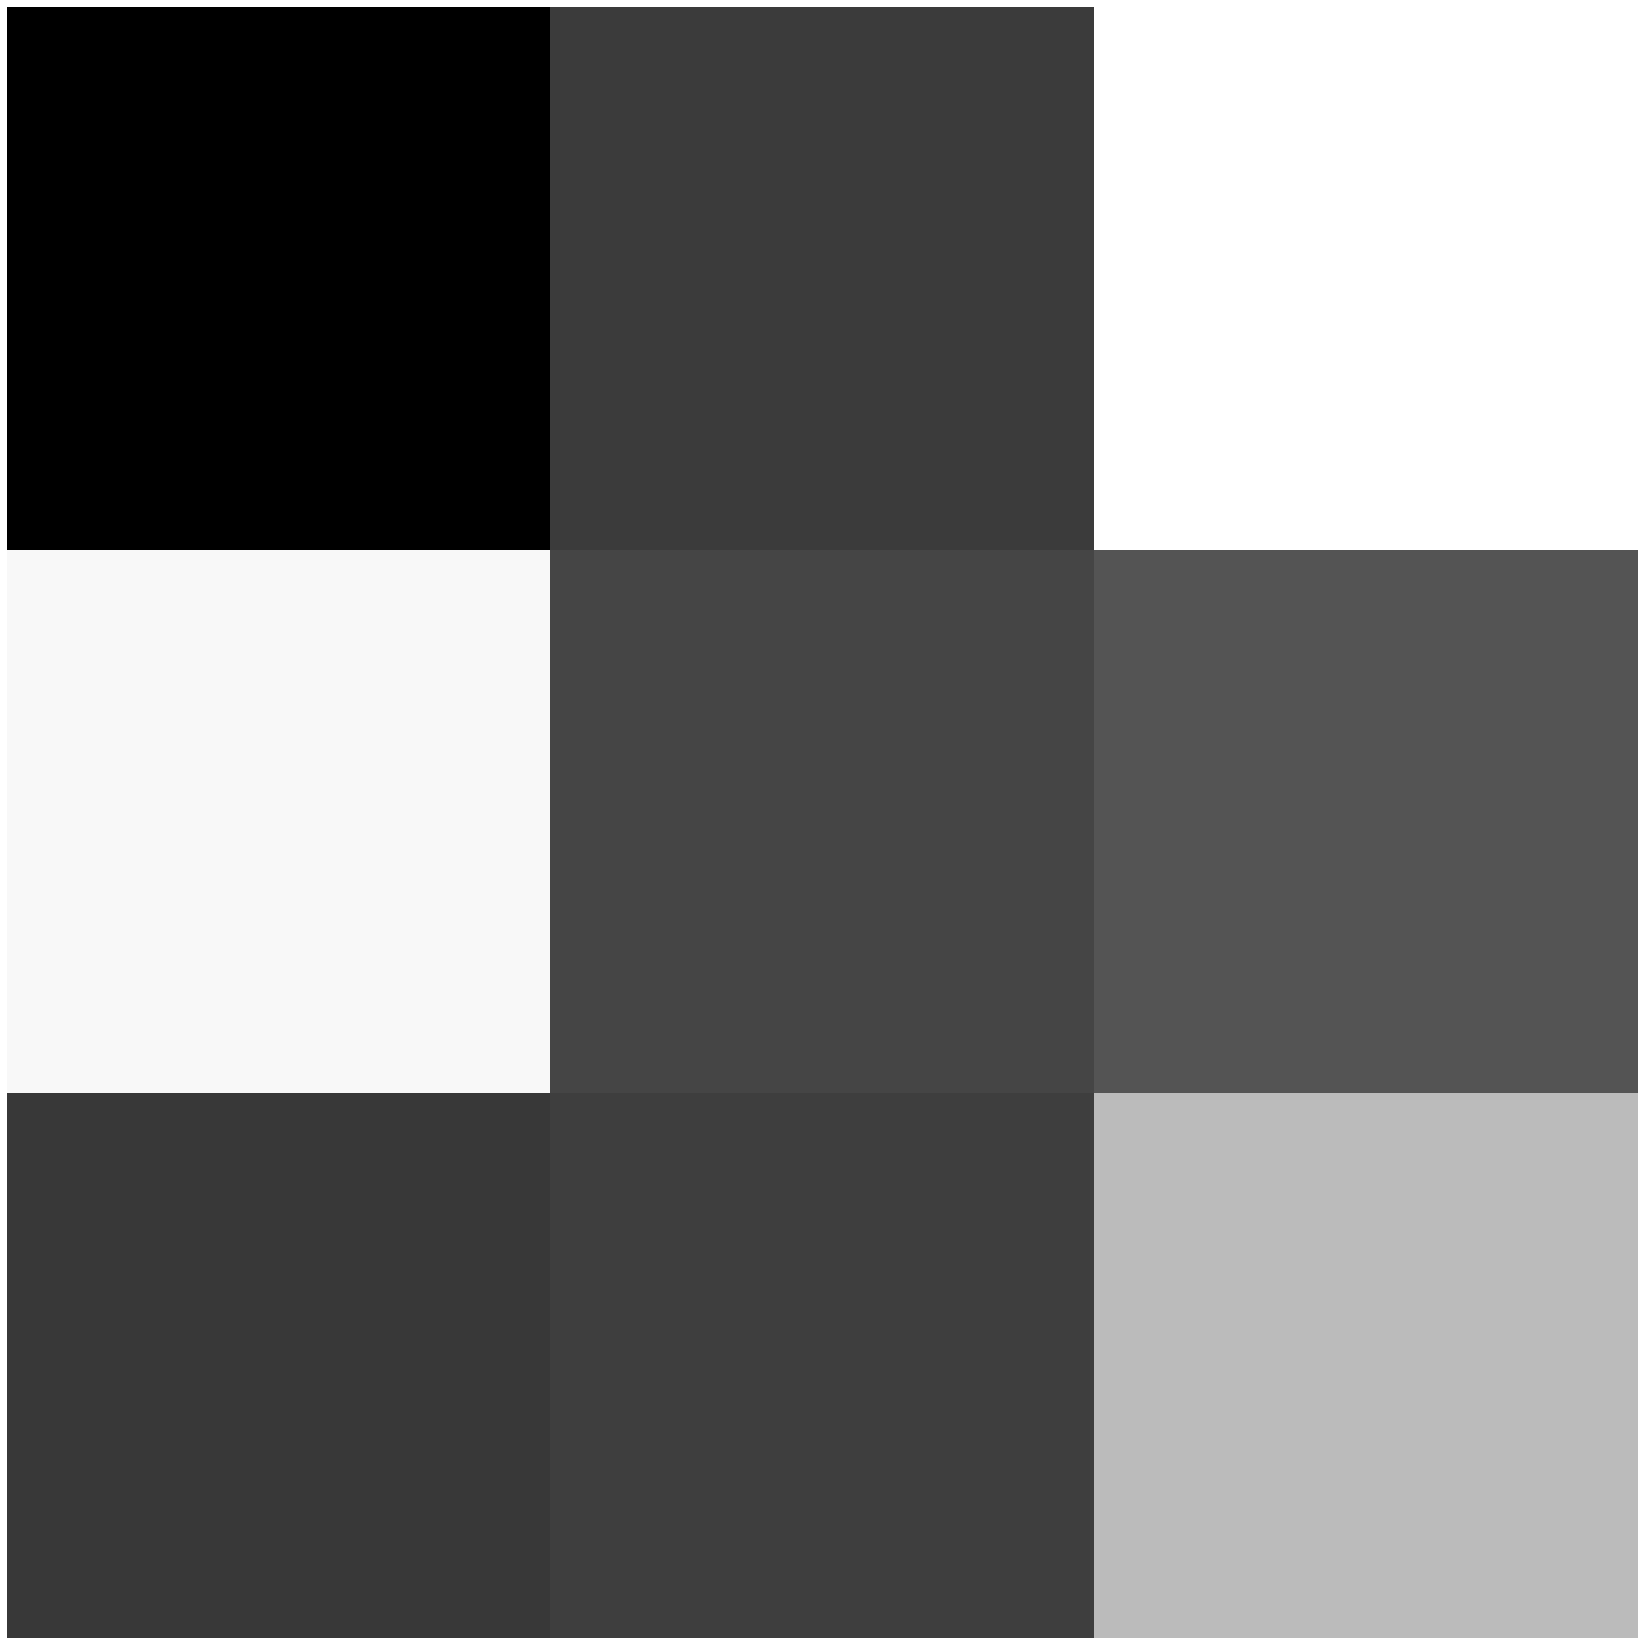

In [9]:
# getting the activations of layers for a given image (so that we can test and compare for the different classes)
def plot_filters(model, img):
    for layer in model.layers:
        if 'conv' in layer.name:
            modelLayer = Model(inputs=model.inputs, outputs=model.get_layer(layer.name).output).predict(img) # get the activations of the 'outputs' layer
            plt.figure(figsize=(30,30))
            size = np.ceil(np.sqrt(modelLayer.shape[3])) # todo: handle different layer shapes
            for filter in range(modelLayer.shape[3]):
                fig.add_subplot(size,size,filter+1)
                plt.imshow(weights_n[:,:,0,filter], cmap='gray') # todo check if this is correct
                plt.axis('off')
      
print("label = ",emotion_dict[np.argmax(y_test[0])])      
plot_filters(model, np.expand_dims(X_test[0],axis=0))

113/113 [==============================] - 3s 25ms/step


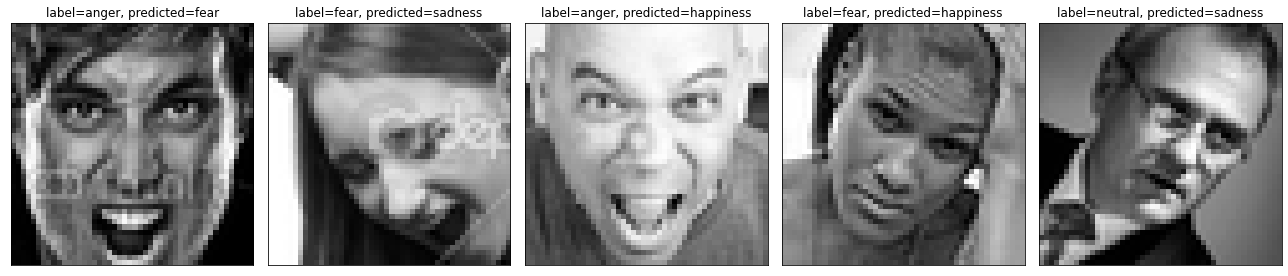

In [10]:
# printing 5 random images with their labels and predictions

predictions = model.predict(X_test, workers=12)
max_predictions = np.argmax(predictions, axis=1)
random_int = np.random.randint(low=0, high=3590-5)

fig = plt.figure(figsize=(18, 5))

for i, prediction in enumerate(max_predictions[random_int:random_int+5]):
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(X_test[random_int+i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'label={emotion_dict[df_test.emotion.iloc[random_int+i]]}, predicted={emotion_dict[prediction]}')
plt.tight_layout()